In [1]:
import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt

Make data.

In [2]:
%load_ext autoreload
%autoreload 2

import malt
import seaborn as sns
from malt.molecule import Molecule

Using backend: pytorch


In [3]:
from malt.data.collections import esol

data = esol()
data.shuffle(seed=1)
data_tr, data_te = data.split([8, 2])

Processing dgl graphs from scratch...
Processing molecule 1000/1128


Make model.

In [16]:
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=32, hidden_features=32,
    ),
    regressor=malt.models.regressor.GPyTorchExactRegressor(
        in_features=32, out_features=2,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
).cuda()

In [46]:
trainer = malt.trainer.get_default_trainer(
    without_player=True,
    batch_size=len(data_tr),
    n_epochs=50,
    learning_rate=1e-3,
    warmup=0
)
model = trainer(model, data_tr)

# model_cpu = model.to('cpu')
r2 = malt.metrics.supervised_metrics.R2()(model, data_tr)

In [41]:
# trainer??

In [47]:
g, y = data_tr.batch(by=['g', 'y'])
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model.condition(g)
    
from malt.metrics.base_metrics import r2
r2(preds.loc, y)

tensor(-1.8980, device='cuda:0', grad_fn=<RsubBackward1>)

Text(0.5, 1.0, 'gpytorch: training')

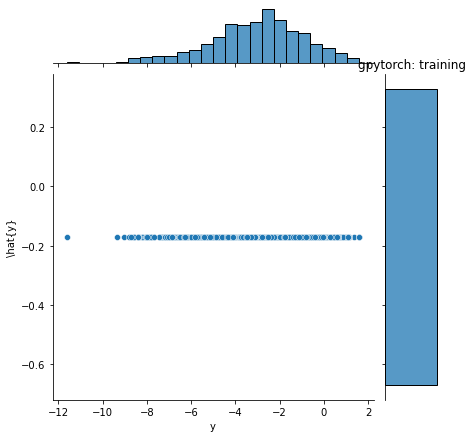

In [48]:
g = sns.jointplot(x = y.ravel().tolist(), y = (preds.loc).tolist())
g.set_axis_labels('y', '\hat{y}')
plt.title('gpytorch: training')